In [2]:
# import the necessary packages for cleaning the data
import os
import pandas as pd
import re
import numpy as np

# read the data
df = pd.read_csv('sample-data.csv')

In [3]:
# A quick look at the data. There are 2 columns, id and description. 
print df.head()

   id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...


In [4]:
# Let's take a closer look at the description and what it has. It starts off with the name then a long description then ending with material detail.
# I am only interested in the name for this project so I will separate it out.
print df['description'][5]

Ascensionist jkt - Our most technical soft shell for full-on mountain pursuits strikes the alpinist's balance between protection and minimalism. The dense 2-way-stretch polyester double weave, with stitchless seams, has exceptional water- and wind-resistance, a rapid dry time and superb breathability. Pared-down detailing provides everything you need and nothing more: a 3-way-adjustable, helmet-compatible hood; a reverse-coil center-front zipper with a DWR (durable water repellent) finish; large external handwarmer pockets (with zipper garages) that are placed above the harness-line; an internal security pocket; articulated arms; self-fabic cuff tabs; a drawcord hem. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Dense stretchy polyester double-weave fabric is exceptionally water- and wind-resistant and is spandex-free for fast dry times; Stitch-free, lap-glued seams speed dry time, improve water resistance and decrease bulk"</li> <li>"Helmet-c

In [5]:
# slices the description returning only the name
def split_description(string):
    # name
    string_split = string.split(' - ',1)
    name = string_split[0]
    
    return name

In [22]:
# let's put the clean data into a new data frame
df_new = pd.DataFrame()
df_new['name'] = df.loc[:,'description'].apply(lambda x: split_description(x))
df_new['id'] = df['id']

In [40]:
# remove numbers and extra spaces from the name
def remove(name):
    new_name = re.sub("[0-9]", '', name)
    new_name = ' '.join(new_name.split())
    return new_name

In [44]:
# let's remove the numbers and extra spaces from the name
df_new['name'] = df_new.loc[:,'name'].apply(lambda x: remove(x))

In [45]:
# now the data is all nice and clean
df_new.head()

,name,id
0,Active classic boxers,1
1,Active sport boxer briefs,2
2,Active sport briefs,3
3,Alpine guide pants,4
4,Alpine wind jkt,5


In [359]:
# use only name to cluster
from sklearn.feature_extraction.text import TfidfVectorizer
#define vectorizer parameters

tfidf_vectorizer = TfidfVectorizer(
                                   use_idf=True,
                                   stop_words = 'english',
                                   ngram_range=(1,4), min_df = 0.05, max_df = 0.8)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df_new['name'])

print(tfidf_matrix.shape)

CPU times: user 9.02 ms, sys: 1.62 ms, total: 10.6 ms
Wall time: 9.25 ms
(500, 5)


In [348]:
tfidf_vectorizer.get_feature_names()

[u'cap', u'jkt', u'pants', u'shirt', u'shorts']

In [349]:
# take a look at random features
import random
features = tfidf_vectorizer.get_feature_names()
for i in range(0,10):
    print features[random.randint(0,len(features))]

pants
jkt
shorts
shirt
cap
pants
shirt
shorts
pants


IndexError: list index out of range

In [350]:
# cosine similarity between each document
from sklearn.metrics.pairwise import cosine_similarity
dist = 1.0 - cosine_similarity(tfidf_matrix)
print dist

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  0.  0.]
 [ 1.  1.  1. ...,  1.  0.  0.]]


In [351]:
# fit kmeans with a range of clusters from 5 to 20. 
from sklearn.cluster import KMeans
num_clusters = range(1,20) # a range of clusters from 5 to 20

%time KM = [KMeans(n_clusters=k, random_state = 1).fit(tfidf_matrix) for k in num_clusters] #train on tdidf matrix

CPU times: user 1.87 s, sys: 6.59 ms, total: 1.87 s
Wall time: 1.87 s


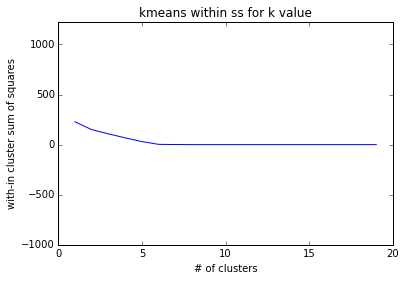

In [352]:
# let's plot the within cluster sum of squares for each cluster # to see which k we should choose
import matplotlib.pyplot as plt
%matplotlib inline
# plot the within cluster sum of squares
with_in_cluster = [KM[k].inertia_ for k in range(0,len(num_clusters))]
plt.plot(num_clusters, with_in_cluster)
plt.ylim(min(with_in_cluster)-1000, max(with_in_cluster)+1000)
plt.ylabel('with-in cluster sum of squares')
plt.xlabel('# of clusters')
plt.title('kmeans within ss for k value')
plt.show()

# plot the within cluster sum of squares and there doesnt seem to be much change from 5 to 100.

In [353]:
# clusters of KM[0] to list
clusters = KM[4].labels_.tolist()
# add cluster to df_new
df_new['cluster'] = clusters
# number of items per cluster
df_new['cluster'].value_counts()

0    266
1     99
2     46
4     45
3     44
dtype: int64

In [354]:
# Print top terms per cluster and names in the cluster
model = KM[4]
print("Top terms per cluster:")
print
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(model.n_clusters):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind],
    print
    print "Cluster %d names:" %i,
    for idx in df_new[df_new['cluster'] == i]['name'].sample(n = 10):
        print ' %s' %idx,
    print
    print

Top terms per cluster:

Cluster 0:  cap  shorts  shirt  pants  jkt
Cluster 0 names:  Merino bottoms  Inga shortie  Solid adour btm  Surf sneaker  Merino crew  All-time shell  Cap crew  Watermaster waders  Sub divider  L/s rashguard

Cluster 1:  shirt  cap  shorts  pants  jkt
Cluster 1 names:  Fezzman shirt  Three trees shirt  Live simply guitar t-shirt  ' logo t-shirt  Drift shirt  Butterfly logo t-shirt  Bouquet t-shirt  Permit silhouette t-shirt  Girl's live simply seal t-shirt  Cap graphic t-shirt

Cluster 2:  pants  shorts  shirt  jkt  cap
Cluster 2 names:  Rain shadow pants  Compound cargo pants  Duck pants  Torrentshell pants  Retro grade pants  Shelled insulator pants  Vitalti pants  Custodian pants  Guidewater pants  Rock guide pants

Cluster 3:  shorts  shirt  pants  jkt  cap
Cluster 3 names:  Continental shorts  Borderless shorts- in.  River shorts  Borderless gi shorts  Cotton board shorts  Baggies shorts  Wavefarer board shorts  Ultra shorts  Girl's boardie shorts  Minimali

In [355]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

xs, ys = pos[:, 0], pos[:, 1]

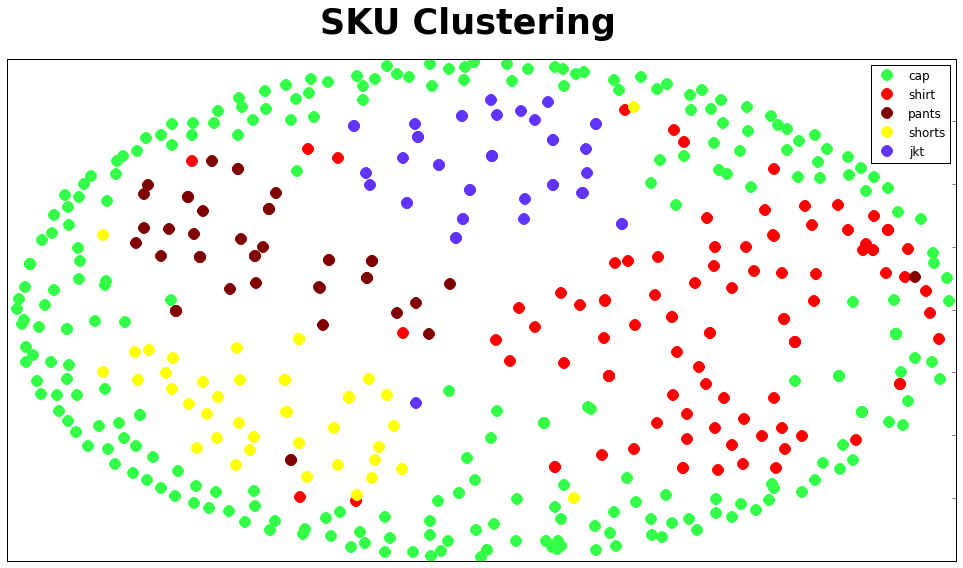

In [376]:
cluster_colors = {0: '#33FF49', 1: '#FF0000', 2: '#800000', 3: '#FFFF00', 4: '#6033FF'}
cluster_labels = {0: 'cap', 1: 'shirt', 2: 'pants', 3: 'shorts', 4: 'jkt'}

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, name=df_new['name'])) 

#group by cluster
groups = df_plot.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label = cluster_labels[name], color = cluster_colors[name], 
            mec='none')
    #ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints = 1)  #show legend with only 1 point

fig.suptitle("SKU Clustering", fontsize = 35, fontweight = 'bold')

plt.show()
